<a href="https://colab.research.google.com/github/philorfa/GraphNeuralNetworks_Projects/blob/main/Cora_Extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch



def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric

!pip install -q tensorboard

     |████████████████████████████████| 7.9 MB 8.1 MB/s 
     |████████████████████████████████| 3.5 MB 7.1 MB/s 
     |████████████████████████████████| 2.3 MB 8.3 MB/s 
     |████████████████████████████████| 747 kB 9.6 MB/s 
     |████████████████████████████████| 370 kB 8.2 MB/s 
     |████████████████████████████████| 482 kB 53.8 MB/s 
     |████████████████████████████████| 41 kB 786 kB/s 


In [2]:
import os.path as osp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn.inits import uniform
from torch.nn import Parameter as Param
from torch import Tensor 


torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


from torch_geometric.nn.conv import MessagePassing
import numpy as np
from torch_sparse import SparseTensor

import networkx as nx
from networkx import *
import matplotlib.pyplot as plt

from torch_geometric.utils import to_networkx

from torch_geometric.transforms import NormalizeFeatures

## Useful Functions

In [3]:
def fullprint(*args, **kwargs):
  from pprint import pprint
  import numpy
  opt = numpy.get_printoptions()
  numpy.set_printoptions(threshold=numpy.inf)
  pprint(*args, **kwargs)
  numpy.set_printoptions(**opt)



#%% Dataset to manage vector to vector data
#training_set = VectorialDataset(input_data=X_train, output_data=y_train)
class VectorialDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, output_data):
        super(VectorialDataset, self).__init__()
        self.input_data = torch.tensor(input_data.astype('f'))
        self.output_data = torch.tensor(output_data.astype('f'))
        
    def __len__(self):
        return self.input_data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.input_data[idx, :], 
                  self.output_data[idx, :])  
        return sample 



# Inside Model Class

def __repr__(self):
        return '{}({}, num_layers={})'.format(self.__class__.__name__,
                                              self.out_channels,
                                              self.num_layers)
        
# Train With Batches
'''
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
'''

'\ndata_size = len(data)\nNUM_GRAPHS_PER_BATCH = 64\nloader = DataLoader(data[:int(data_size * 0.8)], \n                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)\ntest_loader = DataLoader(data[int(data_size * 0.8):], \n                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)\n'

## Read Data

In the following we will use a dataset provided in the dataset collection of PyTorch Geometric ([Here you find all datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)).

In [4]:
data= Planetoid(root="data",name= "Cora",transform=NormalizeFeatures())
data

Processing...
Done!


Cora()

## Data Investigation 1

In [5]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.planetoid.Planetoid'>
Dataset features:  1433
Dataset target:  7
Dataset length:  <bound method InMemoryDataset.len of Cora()>
Dataset sample:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Sample  nodes:  2708
Sample  edges:  10556


In [6]:
print(data.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [7]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
data[0].x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [9]:
data[0].y

tensor([3, 4, 4,  ..., 3, 3, 3])

## Data Investigation 2

In [10]:
fullprint(data[0].x)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [11]:
print(f'Dataset: {data}:')
print('======================')
print(f'Number of graphs: {len(data)}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {data.num_classes}')

print(f'Number of nodes: {data[0].num_nodes}')
print(f'Number of edges: {data[0].num_edges}')
print(f'Average node degree: {data[0].num_edges / data[0].num_nodes:.2f}')
print(f'Number of training nodes: {data[0].train_mask.sum()}')
print(f'Training node label rate: {int(data[0].train_mask.sum()) / data[0].num_nodes:.2f}')
print(f'Contains isolated nodes: {data[0].contains_isolated_nodes()}')
print(f'Contains self-loops: {data[0].contains_self_loops()}')
print(f'Is undirected: {data[0].is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


In [12]:
print("edge_index:\t\t",data.data.edge_index.shape)
print(data.data.edge_index)
print("\n")
print("train_mask:\t\t",data.data.train_mask.shape)
print(data.data.train_mask)
print("\n")
print("x:\t\t",data.data.x.shape)
print(data.data.x)
print("\n")
print("y:\t\t",data.data.y.shape)
print(data.data.y)

edge_index:		 torch.Size([2, 10556])
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])


train_mask:		 torch.Size([2708])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


y:		 torch.Size([2708])
tensor([3, 4, 4,  ..., 3, 3, 3])


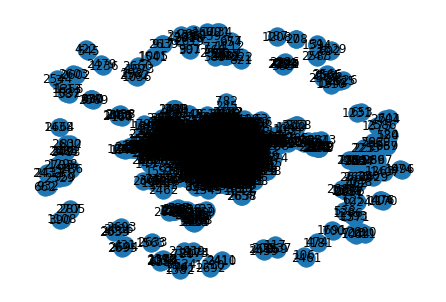

In [13]:
G = to_networkx(data[0], to_undirected=True)
nx.write_gml(G, "graph.gml")
nx.draw(G,with_labels = True)

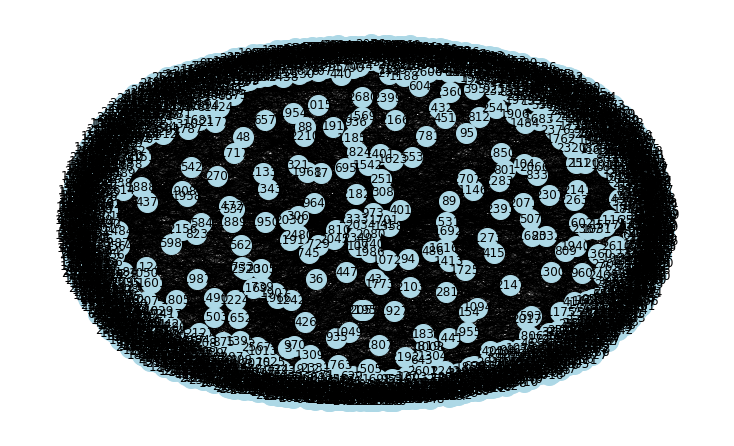

In [14]:
datadraw=nx.read_gml('graph.gml')
plt.figure(figsize=(10,6))
pos = nx.spring_layout(datadraw, k=0.8)
nx.draw(datadraw, pos , with_labels = True, width=0.4, node_color='lightblue', node_size=400)

## Build Model

In [51]:
import torch
from torch.nn import Linear
from torch import tanh
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp



class GCN(torch.nn.Module):
    def __init__(self, num_features, embedding_size, output_size):
        # Init parent
        super(GCN, self).__init__()

        # GCN layers
        self.initial_conv = GCNConv(num_features, embedding_size[0])
        self.conv1 = GCNConv(embedding_size[0], embedding_size[1])
        self.conv2 = GCNConv(embedding_size[1], embedding_size[2])
        self.conv3 = GCNConv(embedding_size[2], embedding_size[3])
        self.lin  = Linear(embedding_size[3], output_size)
        
        # Output layer
        self.out = nn.LogSoftmax(dim=1)
    
    def forward(self, x, edge_index):
        # First Conv layer (Transformation)
        x = self.initial_conv(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Third Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Fourth Message Passing Layer
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.lin(x)
          
        # Apply a final (linear) classifier.
        out = self.out(x)

        return out, x


model = GCN(data.num_features,[512,256,128,64],data.num_classes)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(1433, 512)
  (conv1): GCNConv(512, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (lin): Linear(in_features=64, out_features=7, bias=True)
  (out): LogSoftmax(dim=1)
)
Number of parameters:  907143


In [52]:
model, datas = model.to(device), data[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [23]:
from torch_geometric.loader import DataLoader
from torch.utils.tensorboard import SummaryWriter

loader = DataLoader(data)

In [53]:
def training(model,optimizer,data,writer,show,epochs=150):
    model.train() 
    epoch_loss_train = []
    epoch_acc_train = []
    epoch_loss_val = []
    epoch_acc_val = []

    train_samples=data.train_mask.sum().item()
    val_samples=data.val_mask.sum().item()

    for epoch in range(epochs):
        train_acc=0
        train_loss=0
        val_loss=0
        val_acc=0
        
        optimizer.zero_grad()
        out , _ = model(data.x,data.edge_index)
        train_preds = out[data.train_mask].max(1)[1]
        train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
        train_loss.backward()
        optimizer.step()
            
        val_preds = out[data.val_mask].max(1)[1]
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

        train_acc = train_preds.eq(data.y[data.train_mask]).sum().item()/train_samples
        val_acc = val_preds.eq(data.y[data.val_mask]).sum().item()/val_samples
        
        epoch_acc_train.append(train_acc)
        epoch_acc_val.append(val_acc)
        epoch_loss_train.append(train_loss)
        epoch_loss_val.append(val_loss)
        if (epochs%show==0):
          print("Epoch: {}  \t Train Loss {:.4f} \t Train Accuracy {:.4f} \t Val Loss {:.4f} \t Val Accuracy {:.4f} ".format(epoch+1, float(train_loss), float(train_acc), float(val_loss),float(val_acc)))
        #writer.add_scalar('Train Accuracy',train_acc,epoch) # new line
        #writer.add_scalar('Validation Accuracy',val_acc,epoch)   # new line

    return model,epoch_loss_train,epoch_loss_val,epoch_acc_train,epoch_acc_val


def test(model,data):
  model.eval()
  test_samples = data.test_mask.sum().item()
  with torch.no_grad():
    out , _ = model(data.x,data.edge_index)
    test_preds = out[data.test_mask].max(1)[1]
    test_loss = criterion(out[data.test_mask], data.y[data.test_mask])
    test_acc = test_preds.eq(data.y[data.test_mask]).sum().item()/test_samples
    print("Test Loss {:.4f} \t Test Accuracy {:.4f} ".format(float(test_loss), float(test_acc)))

             

In [54]:
writer = SummaryWriter('runs/GNN_experiment_'+'15_epochs')
mod,train_loss,val_loss,train_acc,val_acc = training(model,optimizer,datas,writer)

Epoch: 1  	 Train Loss 1.9475 	 Train Accuracy 0.1429 	 Val Loss 1.9323 	 Val Accuracy 0.1620 
Epoch: 2  	 Train Loss 1.9461 	 Train Accuracy 0.1643 	 Val Loss 1.9347 	 Val Accuracy 0.1800 
Epoch: 3  	 Train Loss 1.9464 	 Train Accuracy 0.1500 	 Val Loss 1.9393 	 Val Accuracy 0.1500 
Epoch: 4  	 Train Loss 1.9395 	 Train Accuracy 0.1286 	 Val Loss 1.9447 	 Val Accuracy 0.1280 
Epoch: 5  	 Train Loss 1.9406 	 Train Accuracy 0.1214 	 Val Loss 1.9580 	 Val Accuracy 0.0740 
Epoch: 6  	 Train Loss 1.9471 	 Train Accuracy 0.2000 	 Val Loss 1.9658 	 Val Accuracy 0.0820 
Epoch: 7  	 Train Loss 1.9502 	 Train Accuracy 0.1357 	 Val Loss 1.9513 	 Val Accuracy 0.1100 
Epoch: 8  	 Train Loss 1.9407 	 Train Accuracy 0.1786 	 Val Loss 1.9555 	 Val Accuracy 0.1160 
Epoch: 9  	 Train Loss 1.9551 	 Train Accuracy 0.1500 	 Val Loss 1.9443 	 Val Accuracy 0.1640 
Epoch: 10  	 Train Loss 1.9342 	 Train Accuracy 0.2571 	 Val Loss 1.9373 	 Val Accuracy 0.1720 
Epoch: 11  	 Train Loss 1.9323 	 Train Accuracy 0

In [45]:
from tensorflow import summary

ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
test(mod,datas)

Test Loss 2.2045 	 Test Accuracy 0.6920 


##Visualize

In [56]:
import seaborn as sns

def visualize_metric(losses1,losses2):
  # losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
  losses_float1 = [float(loss) for loss in losses1] 
  loss_indices1 = [i for i,l in enumerate(losses_float1)] 
  plt = sns.lineplot(loss_indices1, losses_float1)

  losses_float2 = [float(loss) for loss in losses2] 
  loss_indices2 = [i for i,l in enumerate(losses_float2)] 
  plt = sns.lineplot(loss_indices2, losses_float2)
  


  plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


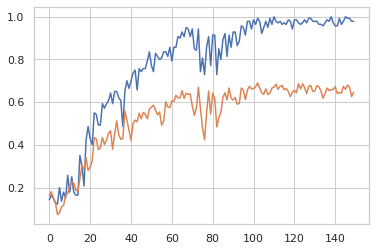

In [57]:
visualize_metric(train_acc,val_acc)

torch.Size([2708, 7])
The correct label is : 2


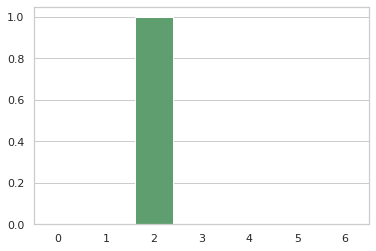

In [62]:
sample = 5
sns.set_theme(style="whitegrid")
print(model(datas.x, datas.edge_index)[0].shape)
print("The correct label is :",datas.y[sample].detach().cpu().numpy())
pred = model(datas.x, datas.edge_index)
pred = [ 10**elem for elem in pred ]
sns.barplot(x=np.array(range(7)), y=pred[0][sample].detach().cpu().numpy())

## GIF of the Embeddings, try to find if clusters appear

In [63]:
from sklearn.manifold import TSNE


def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=70, 
                c=color.detach().cpu().numpy(), 
                cmap="Set2")
    fig.canvas.draw()

    # Convert to numpy
    return plt2arr(fig)


# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

Epoch: 1  	 Train Loss 1.9473 	 Train Accuracy 0.1714 	 Val Loss 1.9371 	 Val Accuracy 0.2900 
Epoch: 1  	 Train Loss 1.9462 	 Train Accuracy 0.1857 	 Val Loss 1.9361 	 Val Accuracy 0.2900 
Epoch: 1  	 Train Loss 1.9453 	 Train Accuracy 0.1214 	 Val Loss 1.9370 	 Val Accuracy 0.1720 
Epoch: 1  	 Train Loss 1.9519 	 Train Accuracy 0.1500 	 Val Loss 1.9451 	 Val Accuracy 0.1120 
Epoch: 1  	 Train Loss 1.9403 	 Train Accuracy 0.1571 	 Val Loss 1.9445 	 Val Accuracy 0.1260 
Epoch: 1  	 Train Loss 1.9418 	 Train Accuracy 0.1500 	 Val Loss 1.9413 	 Val Accuracy 0.1500 
Epoch: 1  	 Train Loss 1.9301 	 Train Accuracy 0.1357 	 Val Loss 1.9484 	 Val Accuracy 0.1320 
Epoch: 1  	 Train Loss 1.9444 	 Train Accuracy 0.1214 	 Val Loss 1.9631 	 Val Accuracy 0.1020 
Epoch: 1  	 Train Loss 1.9234 	 Train Accuracy 0.1500 	 Val Loss 1.9454 	 Val Accuracy 0.1280 
Epoch: 1  	 Train Loss 1.9029 	 Train Accuracy 0.1857 	 Val Loss 1.9296 	 Val Accuracy 0.1680 
Epoch: 1  	 Train Loss 1.8544 	 Train Accuracy 0.1

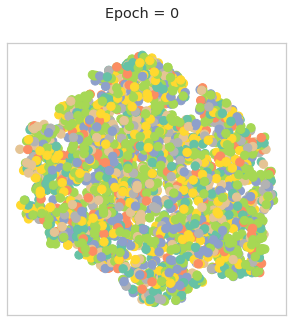

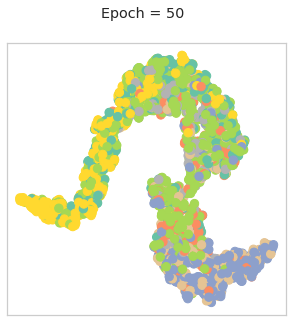

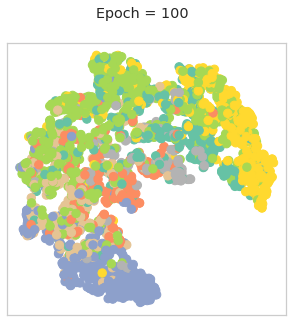

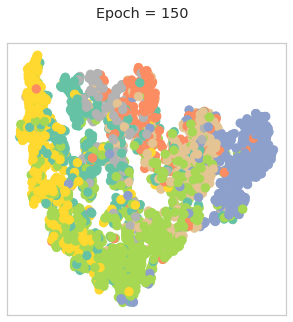

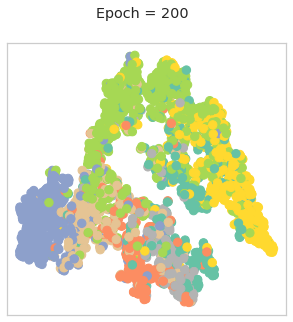

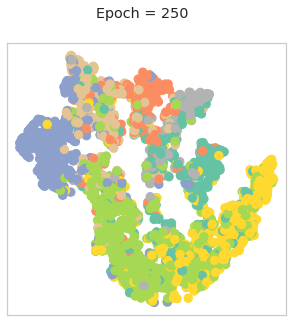

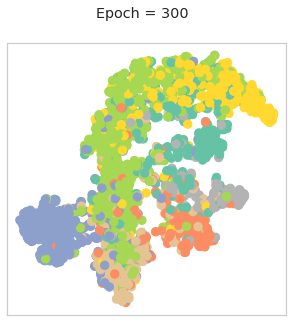

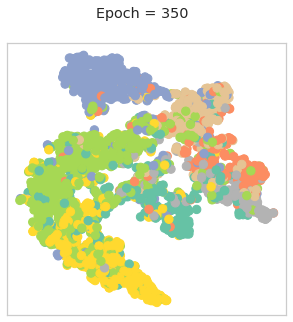

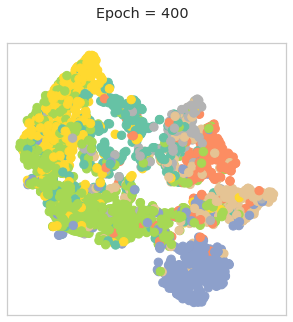

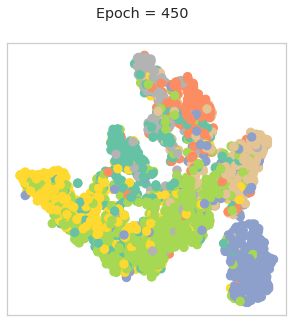

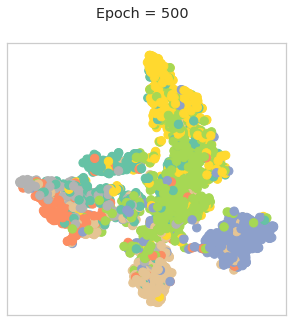

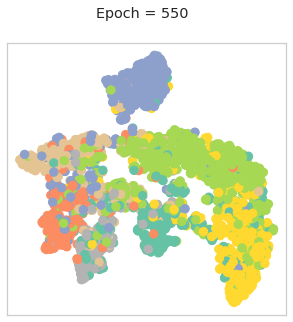

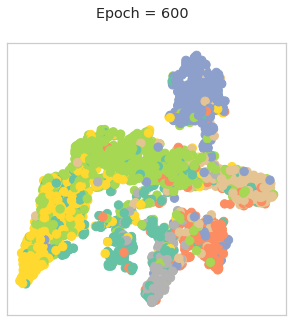

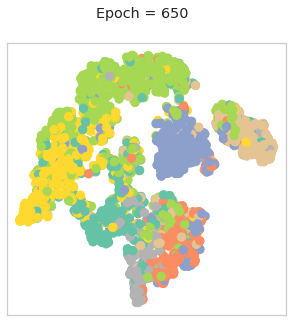

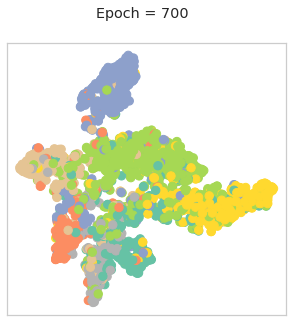

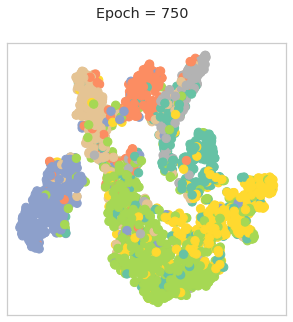

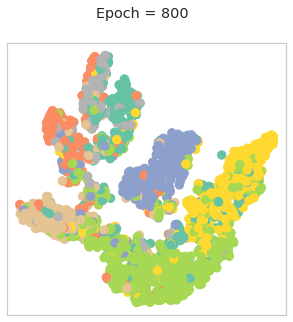

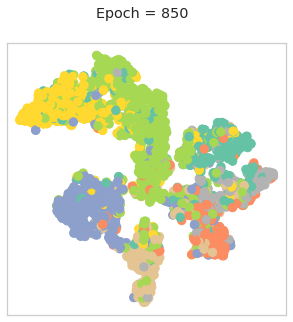

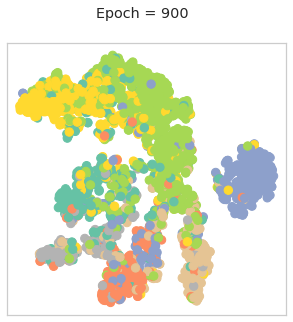

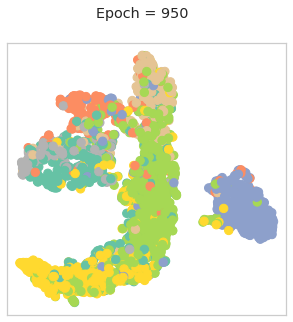

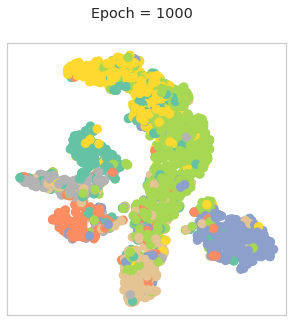

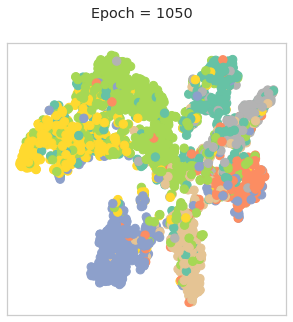

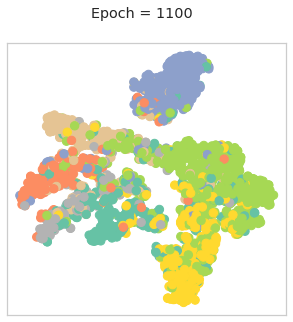

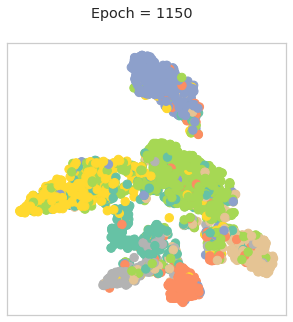

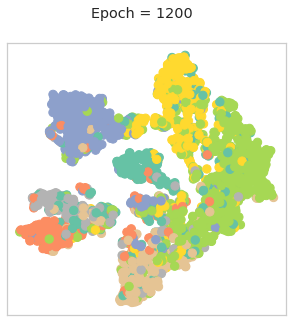

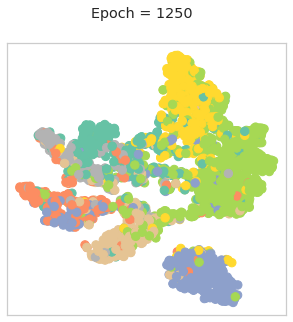

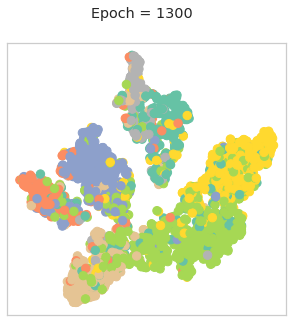

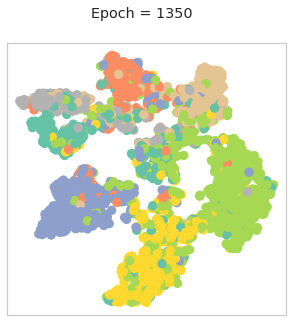

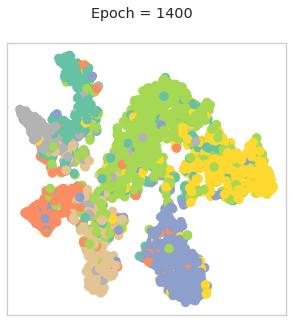

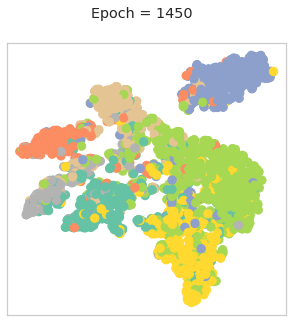

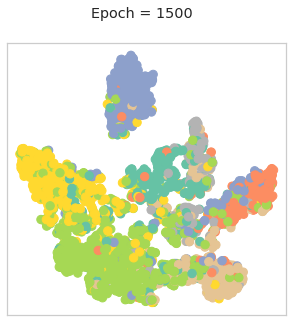

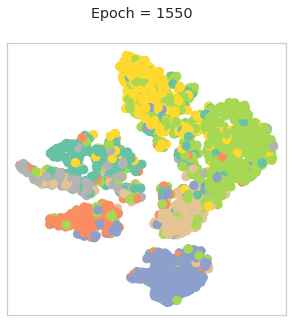

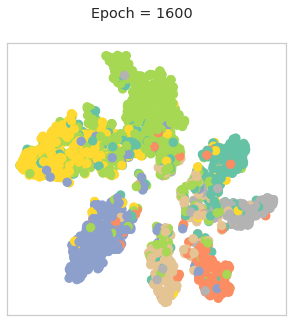

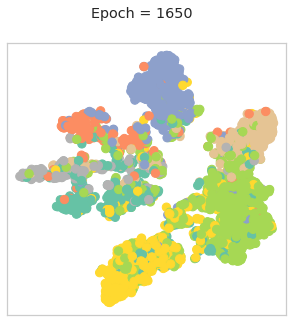

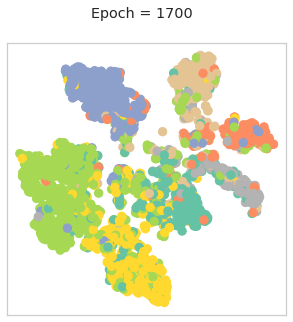

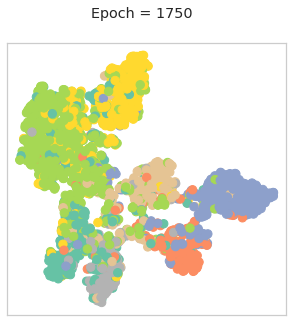

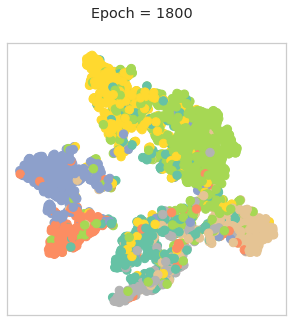

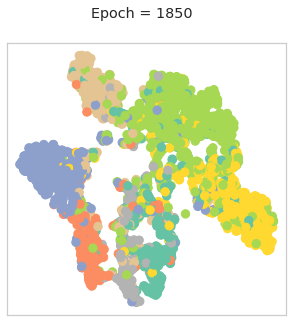

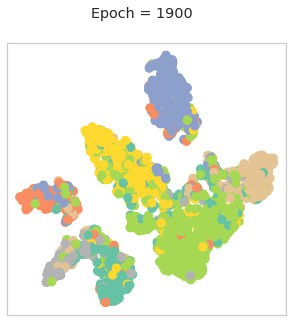

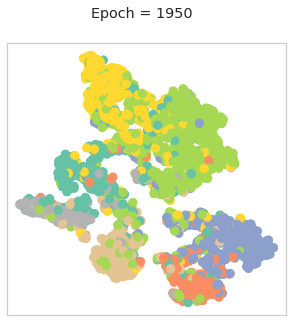

In [65]:
# Ignore deprecation warnings here
import warnings
warnings.filterwarnings('ignore')

# Train the model and save visualizations
images = []
for epoch in range(0, 2000):
    loss = training(model,optimizer,datas,writer,epochs=1)
    if epoch % 50 == 0:
      _,out = model(datas.x, datas.edge_index)
      images.append(visualize(out, color=datas.y, epoch=epoch))
print("TSNE Visualization finished.")

In [66]:
!pip install moviepy

In [67]:
from moviepy.editor import ImageSequenceClip
fps = 1
filename = "/content/embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3416064/45929032 bytes (7.4%)7331840/45929032 bytes (16.0%)11452416/45929032 bytes (24.9%)15417344/45929032 bytes (33.6%)19505152/45929032 bytes (42.5%)23502848/45929032 bytes (51.2%)26083328/45929032 bytes (56.8%)28844032/45929032 bytes (62.8%)31744000/45929032 bytes (69.1%)33579008/45929032 bytes (73.1%)34807808/45929032 bytes (75.8%)37150720/45929032 bytes (80.9%)

 98%|█████████▊| 40/41 [00:01<00:00, 22.37it/s]
